<a href="https://colab.research.google.com/github/sererkim/studentData/blob/main/Alzheimer_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import plotly.express as px
data = pd.read_csv('/content/oasis_cross-sectional.csv')

# Class Distribution using CDR
class_distribution = data['CDR'].value_counts().reset_index()
class_distribution.columns = ['CDR', 'Count']
fig = px.bar(class_distribution, x='CDR', y='Count', title='Class Distribution by Clinical Dementia Rating (CDR)',
             labels={'CDR': 'Clinical Dementia Rating', 'Count': 'Frequency'})
fig.show()

# Correlation Matrix Heatmap
corr_matrix = data.select_dtypes(include=['float64', 'int']).corr()
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                title="Correlation Matrix of Numerical Features")
fig.show()

# Histograms for Numeric Features
numeric_columns = data.select_dtypes(include=['float64', 'int']).columns
for column in numeric_columns:
    fig = px.histogram(data, x=column, marginal='box', title=f'Distribution of {column}')
    fig.show()

# Box Plots for Numeric Features
for column in numeric_columns:
    fig = px.box(data, y=column, title=f'Box Plot of {column}')
    fig.show()

# Pair Plot for a Subset of Numeric Features
numeric_columns = numeric_columns[:5]
fig = px.scatter_matrix(data,
                        dimensions=numeric_columns,
                        title='Pair Plot of Numeric Features')
fig.show()

In [6]:
import numpy as np
data = pd.read_csv('/content/oasis_cross-sectional.csv')
data = data.select_dtypes(include=[np.number])  # This excludes non-numeric columns like 'Gender'


# Impute missing values with median (experiment with it ;) )
data.fillna(data.median(), inplace=True)

# Check if CDR is numeric or categorical, convert if necessary
data['CDR'] = data['CDR'].astype(str)

# Generate box plots for each numeric feature grouped by CDR
numeric_columns = data.select_dtypes(include=['float64', 'int']).columns
for column in numeric_columns:
    fig = px.box(data, y=column, x='CDR', color='CDR', title=f'Box Plot of {column} by Clinical Dementia Rating (CDR)')
    fig.update_layout(xaxis_title='CDR', yaxis_title=column)
    fig.show()

Count of missing values per column:
ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64


<Figure size 1200x800 with 0 Axes>

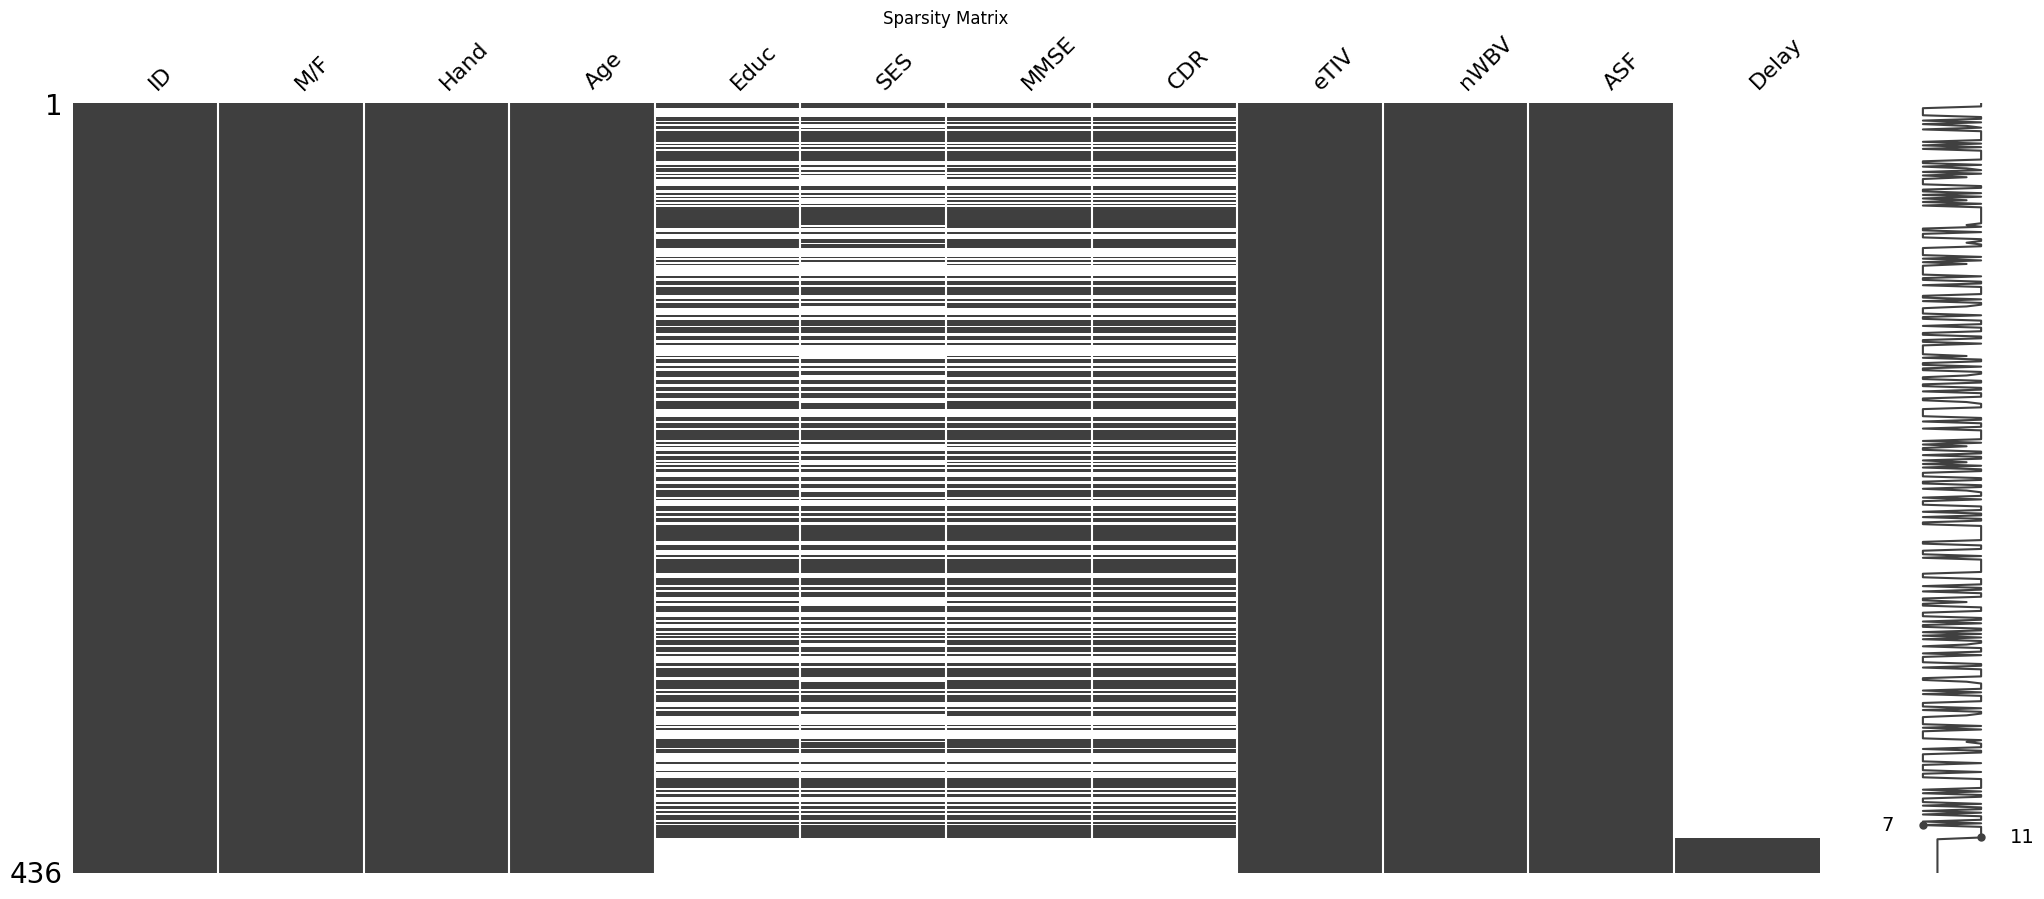

In [10]:
import matplotlib.pyplot as plt
import missingno as msno
data = pd.read_csv('/content/oasis_cross-sectional.csv')

# Display the count of missing values per column
print("Count of missing values per column:")
print(data.isnull().sum())

# Visualize the sparsity matrix of the dataset
plt.figure(figsize=(12, 8))
msno.matrix(data)
plt.title('Sparsity Matrix')
plt.show()

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data = pd.read_csv('/content/oasis_cross-sectional.csv')
data.drop('ID', axis=1, inplace=True)

# Select numerical features for PCA
features = data.select_dtypes(include=[np.number]).columns.tolist()

# Impute missing values using the median for each column
imputer = SimpleImputer(strategy='median')
data[features] = imputer.fit_transform(data[features])

# Normalize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Concatenate the class labels (CDR) and principal components
final_df = pd.concat([principal_df, data['CDR'].reset_index(drop=True)], axis=1)

# Visualize in 3D
fig = px.scatter_3d(final_df, x='PC1', y='PC2', z='PC3', color='CDR',
                        title='3D PCA of MRI Data',
                        labels={'CDR': 'Clinical Dementia Rating'})
fig.show()

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
data = pd.read_csv('/content/oasis_cross-sectional.csv')
data.drop(columns=['ID'], inplace=True)

# Impute missing values with median  (again I encourage you to experiment with the approach ;) )
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data.select_dtypes(include=[np.number])), columns=data.select_dtypes(include=[np.number]).columns)

# Encode categorical variables
le = LabelEncoder()
data_imputed['CDR'] = le.fit_transform(data['CDR'])

# Separate features and target
X = data_imputed.drop('CDR', axis=1)
y = data_imputed['CDR']


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Initialize a dictionary to store the results
model_results = {}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, zero_division=0)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(report)

    # Save results to the dictionary
    model_results[name] = {
        'Accuracy': accuracy,
        'Classification Report': report
    }

for model_name, results in model_results.items():
    with open(f"{model_name}_results.txt", "w") as file:
        file.write(f"Accuracy: {results['Accuracy']}\n")
        file.write("Classification Report:\n")
        file.write(results['Classification Report'])

print("Model results saved to files.")

Random Forest Accuracy: 0.8409
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        25
           1       0.47      0.64      0.54        11
           2       0.50      0.14      0.22         7
           3       0.00      0.00      0.00         1
           4       1.00      0.98      0.99        44

    accuracy                           0.84        88
   macro avg       0.56      0.54      0.52        88
weighted avg       0.83      0.84      0.83        88

XGBoost Accuracy: 0.8068
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.35      0.55      0.43        11
           2       0.50      0.29      0.36         7
           3       0.00      0.00      0.00         1
           4       1.00      0.98      0.99        44

    accuracy                           0.81        88
   macro avg       0.54      0.52      0.52        88
weighted avg       0.

In [29]:
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value=None):
        self.fill_value = fill_value

    def fit(self, X, y=None):
        # Define the fill value as the median or a constant provided during initialization
        # Feel free to use this as a support for your own imputation strategies
        self.fill_value_ = np.median(X, axis=0) if self.fill_value is None else self.fill_value
        return self

    def transform(self, X, y=None):
        return np.where(np.isnan(X), self.fill_value_, X)

def evaluate_models(data_path, imputer, verbose=False):
    # Load the data
    data = pd.read_csv(data_path)
    data.drop(columns=['ID'], inplace=True)

    # Apply imputation
    data_imputed = pd.DataFrame(imputer.fit_transform(data.select_dtypes(include=[np.number])),
                                columns=data.select_dtypes(include=[np.number]).columns)

    # Encode categorical variables
    le = LabelEncoder()
    data['CDR'] = le.fit_transform(data['CDR'])
    data_imputed['CDR'] = data['CDR']

    # Separate features and target
    X = data_imputed.drop('CDR', axis=1)
    y = data_imputed['CDR']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define resampling strategies
    resampling_strategies = {
        'Random Over-Sampling': RandomOverSampler(random_state=42)
    }

    # Define the models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }

    # Initialize results storage
    model_results = {}

    # Process each resampling strategy
    for resample_name, resampler in resampling_strategies.items():
        X_resampled, y_resampled = resampler.fit_resample(X_scaled, y)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

        model_results[resample_name] = {}

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            report = classification_report(y_test, predictions, zero_division=0)

            model_results[resample_name][model_name] = {
                'Accuracy': accuracy,
                'Classification Report': report
            }

            if verbose:
                print(f"Model: {model_name}")
                print(f"Resampling: {resample_name}")
                print(f"Accuracy: {accuracy}")
                print("Classification Report:")
                print(report)

    # Optionally save the results to files
    for resample_name, results_by_model in model_results.items():
        for model_name, results in results_by_model.items():
            with open(f"{resample_name}_{model_name}_results.txt", "w") as file:
                file.write(f"Model: {model_name}\n")
                file.write(f"Resampling: {resample_name}\n")
                file.write(f"Accuracy: {results['Accuracy']}\n")
                file.write("Classification Report:\n")
                file.write(results['Classification Report'])

    if verbose:
        print("Model results saved to files.")

# Example usage with a custom imputer
custom_imputer = CustomImputer(fill_value=0)  # You can define any fill value or leave it to compute the median
evaluate_models('/content/oasis_cross-sectional.csv', custom_imputer, verbose=True)

Model: Random Forest
Resampling: Random Over-Sampling
Accuracy: 0.9601990049751243
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        44
           1       0.89      0.93      0.91        43
           2       0.91      1.00      0.95        30
           3       1.00      1.00      1.00        39
           4       1.00      1.00      1.00        45

    accuracy                           0.96       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.96      0.96      0.96       201

Model: XGBoost
Resampling: Random Over-Sampling
Accuracy: 0.9552238805970149
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        44
           1       0.87      0.93      0.90        43
           2       0.91      1.00      0.95        30
           3       1.00      1.00      1.00        39
           4       1.00      1.00 